In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


c:\Users\Trin Uthaisang\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


In [3]:

# --- IMPORTS (Add these if not already present) ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd

# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train_raw = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2014 and < 2019)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val_raw = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test_raw = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

# --- IMPUTATION (Handle NaNs before scaling) ---
imputer = SimpleImputer(strategy='mean')  # Or 'median' if data is skewed
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=feature_cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_raw), columns=feature_cols)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=feature_cols)

# Optional: Print NaN counts to verify (should be 0 after imputation)
print("NaNs in X_train_imputed:", X_train_imputed.isnull().sum().sum())
print("NaNs in X_val_imputed:", X_val_imputed.isnull().sum().sum())
print("NaNs in X_test_imputed:", X_test_imputed.isnull().sum().sum())

X_train_imputed.head(5)


Total Features Used: 23
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,avg_solar_winter,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude


NaNs in X_train_imputed: 0
NaNs in X_val_imputed: 0
NaNs in X_test_imputed: 0


,year,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,avg_solar_winter,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982.0,2241.4,2181.766667,2097.64,150.63,113.69,34.44,26.56,325.32,16.286854,...,18.195158,0.880000,12.286667,21.830000,11.800000,11.699167,18529.157781,5.778887,34.53,69.17
1,1983.0,2199.4,2204.533333,2156.56,139.74,172.94,3.65,57.21,373.54,16.286854,...,18.195158,-0.713333,9.976667,21.856667,11.483333,10.650833,18529.157781,6.672946,34.53,69.17
2,1984.0,2258.1,2232.966667,2200.56,60.60,202.73,9.34,0.58,273.25,16.286854,...,18.195158,0.953333,9.246667,22.393333,12.940000,11.383333,18529.157781,7.152971,34.53,69.17
3,1985.0,2241.6,2233.033333,2222.66,68.62,89.17,17.24,21.07,196.10,11.200000,...,19.215833,-1.406667,13.023333,24.120000,11.816667,11.888333,18529.157781,9.178255,34.53,69.17
4,1986.0,2248.2,2249.300000,2237.74,75.65,65.67,5.44,8.33,155.09,11.366667,...,18.741667,1.843333,12.990000,22.946667,12.266667,12.511667,18529.157781,9.224020,34.53,69.17


In [4]:
# =========================
# 1. Torch Datasets & Loaders
# =========================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Make sure these exist from previous cells:
# X_train_imputed, X_val_imputed, X_test_imputed
# y_train, y_val, y_test

class TabularDataset(Dataset):
    def __init__(self, X, y):
        """
        X: pandas DataFrame or numpy array (n_samples, n_features)
        y: pandas Series or numpy array (n_samples,)
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Create dataset objects
train_dataset = TabularDataset(X_train_imputed, y_train)
val_dataset   = TabularDataset(X_val_imputed, y_val)
test_dataset  = TabularDataset(X_test_imputed, y_test)

# Dataloaders
batch_size = 24  # you can tune this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

input_dim = X_train_imputed.shape[1]
print(f"Input dim: {input_dim}, Train samples: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Input dim: 23, Train samples: 3579, Val: 575, Test: 575


In [5]:
# =========================
# 2. Transformer Regression Model (TFT-style)
# =========================

class TransformerRegressor(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        # Project feature vector -> model dimension
        self.input_proj = nn.Linear(input_dim, d_model)

        # Transformer encoder (similar spirit to your TFT encoder)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="relu",
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output head
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: (batch_size, input_dim)
        We treat features as a single 'token':
          - project to d_model
          - add fake sequence dimension of length 1
        """
        # (B, F) -> (B, d_model)
        x = self.input_proj(x)

        # (B, d_model) -> (B, 1, d_model)
        x = x.unsqueeze(1)

        # Transformer encoder (sequence length = 1 here)
        x = self.encoder(x)  # (B, 1, d_model)

        # Pool over sequence dimension (trivial when seq_len=1)
        x = x.mean(dim=1)    # (B, d_model)

        x = self.dropout(x)
        out = self.fc_out(x).squeeze(-1)  # (B,)

        return out


In [6]:
# =========================
# 3. Training & Evaluation
# =========================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TransformerRegressor(
    input_dim=input_dim,
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


from sklearn.metrics import mean_squared_error

# ---------- helper: RMSE ----------
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ---------- helper: one epoch ----------
def run_epoch(loader, model, criterion, optimizer=None):
    """
    If optimizer is provided -> training mode
    Otherwise -> evaluation mode
    """
    if optimizer is not None:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.set_grad_enabled(optimizer is not None):
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(y_batch.detach().cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return avg_loss, all_preds, all_targets


# =========================
# TRAINING LOOP (Transformer model)
# =========================

history = {
    "train_loss": [],
    "val_loss": [],
    "train_rmse": [],
    "val_rmse": []
}

num_epochs = 150
best_val_loss = float("inf")
best_state = None

for epoch in range(num_epochs):

    # -------- TRAIN --------
    train_loss, train_preds, train_targets = run_epoch(
        train_loader, model, criterion, optimizer
    )
    train_rmse = compute_rmse(train_targets, train_preds)

    # -------- VAL --------
    val_loss, val_preds, val_targets = run_epoch(
        val_loader, model, criterion, optimizer=None
    )
    val_rmse = compute_rmse(val_targets, val_preds)

    # Scheduler (optional, if you defined it)
    try:
        scheduler.step(val_loss)
    except NameError:
        pass

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    # Track best model by val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()

    # -------- PRINT in your format --------
    if epoch == 0 or (epoch % 20 == 0) or epoch == num_epochs - 1:
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}"
        )

# Load best weights
if best_state is not None:
    model.load_state_dict(best_state)

print(f"\nBest validation loss (RMSE): {best_val_loss:.4f}")


Using device: cpu
Model parameters: 202,369
Epoch 0/150 | Train RMSE: 3831.24 | Val RMSE: 4585.86
Epoch 20/150 | Train RMSE: 1512.05 | Val RMSE: 2026.16
Epoch 40/150 | Train RMSE: 688.62 | Val RMSE: 881.11
Epoch 60/150 | Train RMSE: 596.92 | Val RMSE: 617.08
Epoch 80/150 | Train RMSE: 564.12 | Val RMSE: 581.03
Epoch 100/150 | Train RMSE: 545.85 | Val RMSE: 559.82
Epoch 120/150 | Train RMSE: 545.28 | Val RMSE: 554.10
Epoch 140/150 | Train RMSE: 544.67 | Val RMSE: 558.04
Epoch 149/150 | Train RMSE: 547.00 | Val RMSE: 557.84

Best validation loss (RMSE): 307032.2393


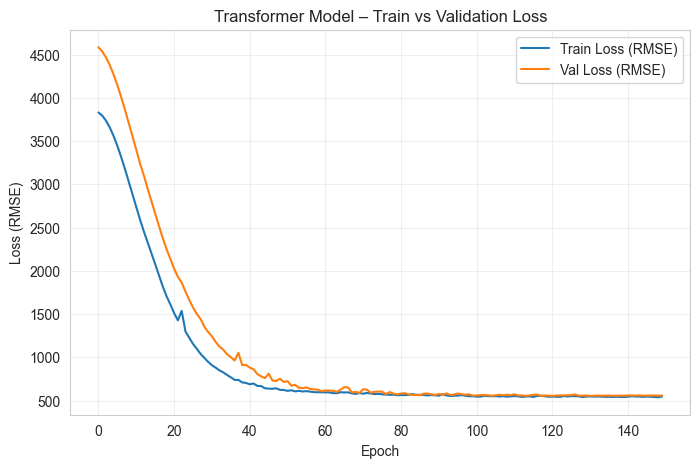

In [7]:

import matplotlib.pyplot as plt

epochs = range(len(history["train_loss"]))

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_rmse"], label="Train Loss (RMSE)")
plt.plot(epochs, history["val_rmse"], label="Val Loss (RMSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.title("Transformer Model – Train vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate on test set
model.eval()
test_loss, test_preds, test_targets = run_epoch(
    test_loader, model, criterion, optimizer=None
)

# Flatten to 1D
test_preds = test_preds.reshape(-1)
test_targets = test_targets.reshape(-1)

test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
test_r2   = r2_score(test_targets, test_preds)

print(f"Test MSE:  {test_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²:   {test_r2:.4f}")

Test MSE:  293625.6900
Test RMSE: 541.8724
Test R²:   0.9409


In [9]:
import optuna
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ---------- RMSE ----------
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ---------- one epoch ----------
def run_epoch(loader, model, criterion, optimizer=None):
    """
    If optimizer is provided -> training mode
    Otherwise -> evaluation mode
    """
    if optimizer is not None:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.set_grad_enabled(optimizer is not None):
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(y_batch.detach().cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return avg_loss, all_preds, all_targets


# ---------- dataloaders factory (for different batch sizes) ----------
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

input_dim = train_dataset[0][0].shape[0]
print("Input dim:", input_dim)


Input dim: 23


In [12]:
def objective(trial):
    # ---- hyperparameters to search ----
    d_model         = trial.suggest_categorical("d_model", [32, 64, 96, 128])
    nhead           = trial.suggest_categorical("nhead", [2, 4, 8])
    num_layers      = trial.suggest_int("num_layers", 1, 4)
    dim_feedforward = trial.suggest_int("dim_feedforward", 32, 128, step=32)
    dropout         = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr              = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size      = trial.suggest_categorical("batch_size", [8, 16, 32, 64])

    # ---- dataloaders for this batch size ----
    train_loader, val_loader, _ = create_dataloaders(batch_size)

    # ---- model, optimizer, loss ----
    model = TransformerRegressor(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # shorter training for tuning
    max_epochs = 60
    best_val_rmse = float("inf")
    patience = 10
    patience_counter = 0

    for epoch in range(max_epochs):
        # train
        train_loss, train_preds, train_targets = run_epoch(
            train_loader, model, criterion, optimizer
        )

        # validate
        val_loss, val_preds, val_targets = run_epoch(
            val_loader, model, criterion, optimizer=None
        )

        val_rmse = compute_rmse(val_targets, val_preds)

        # report to Optuna
        trial.report(val_rmse, epoch)

        # pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # early stopping logic on val RMSE
        if val_rmse < best_val_rmse - 1e-3:
            best_val_rmse = val_rmse
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_rmse


In [13]:
study_name = f"{CHOSEN_CROP}_Transformer_Optuna" if "CHOSEN_CROP" in globals() else "Transformer_Optuna"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name
)

study.optimize(objective, n_trials=10, show_progress_bar=True)

print("Number of finished trials:", len(study.trials))
print("Best trial value (Val RMSE):", study.best_trial.value)
print("Best trial params:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")


[I 2025-12-03 01:23:00,156] A new study created in memory with name: rice_Transformer_Optuna
Best trial: 0. Best value: 4060.94:  10%|█         | 1/10 [00:17<02:38, 17.57s/it]

[I 2025-12-03 01:23:17,726] Trial 0 finished with value: 4060.942132067385 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 32, 'dropout': 0.4, 'lr': 0.00024874526089790493, 'batch_size': 32}. Best is trial 0 with value: 4060.942132067385.


Best trial: 0. Best value: 4060.94:  20%|██        | 2/10 [00:35<02:21, 17.70s/it]

[I 2025-12-03 01:23:35,514] Trial 1 finished with value: 4543.714119528208 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.0, 'lr': 0.000137516990586291, 'batch_size': 64}. Best is trial 0 with value: 4060.942132067385.


Best trial: 2. Best value: 2302.69:  30%|███       | 3/10 [01:02<02:32, 21.80s/it]

[I 2025-12-03 01:24:02,204] Trial 2 finished with value: 2302.6906001458383 and parameters: {'d_model': 96, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 64, 'dropout': 0.0, 'lr': 0.00225935553346958, 'batch_size': 64}. Best is trial 2 with value: 2302.6906001458383.


Best trial: 3. Best value: 1951.39:  40%|████      | 4/10 [02:04<03:47, 37.83s/it]

[I 2025-12-03 01:25:04,612] Trial 3 finished with value: 1951.391042308025 and parameters: {'d_model': 64, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 64, 'dropout': 0.30000000000000004, 'lr': 0.0007122984201032943, 'batch_size': 32}. Best is trial 3 with value: 1951.391042308025.


Best trial: 4. Best value: 1060.87:  50%|█████     | 5/10 [02:57<03:37, 43.42s/it]

[I 2025-12-03 01:25:57,934] Trial 4 finished with value: 1060.8720469500552 and parameters: {'d_model': 96, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.4, 'lr': 0.0016866783007642395, 'batch_size': 32}. Best is trial 4 with value: 1060.8720469500552.


Best trial: 5. Best value: 602.451:  60%|██████    | 6/10 [06:14<06:22, 95.64s/it]

[I 2025-12-03 01:29:14,938] Trial 5 finished with value: 602.4514243903818 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 32, 'dropout': 0.2, 'lr': 0.00046529137180765324, 'batch_size': 8}. Best is trial 5 with value: 602.4514243903818.


Best trial: 6. Best value: 567.316:  70%|███████   | 7/10 [21:10<17:52, 357.36s/it]

[I 2025-12-03 01:44:11,130] Trial 6 finished with value: 567.3162698178152 and parameters: {'d_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 96, 'dropout': 0.0, 'lr': 0.0008031532045239125, 'batch_size': 8}. Best is trial 6 with value: 567.3162698178152.


Best trial: 6. Best value: 567.316:  80%|████████  | 8/10 [7:36:08<4:45:03, 8551.88s/it]

[I 2025-12-03 08:59:08,900] Trial 7 finished with value: 1595.6428955126519 and parameters: {'d_model': 96, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.5, 'lr': 0.001104318617952708, 'batch_size': 8}. Best is trial 6 with value: 567.3162698178152.


Best trial: 6. Best value: 567.316:  90%|█████████ | 9/10 [7:36:12<1:37:59, 5879.54s/it]

[I 2025-12-03 08:59:12,456] Trial 8 pruned. 


Best trial: 6. Best value: 567.316: 100%|██████████| 10/10 [7:36:14<00:00, 2737.47s/it] 

[I 2025-12-03 08:59:14,892] Trial 9 pruned. 
Number of finished trials: 10
Best trial value (Val RMSE): 567.3162698178152
Best trial params:
  d_model: 128
  nhead: 2
  num_layers: 2
  dim_feedforward: 96
  dropout: 0.0
  lr: 0.0008031532045239125
  batch_size: 8


C:\Users\Trin Uthaisang\AppData\Local\Temp\ipykernel_14188\2828925449.py:11: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study)


AttributeError: 'Axes' object has no attribute 'update_layout'

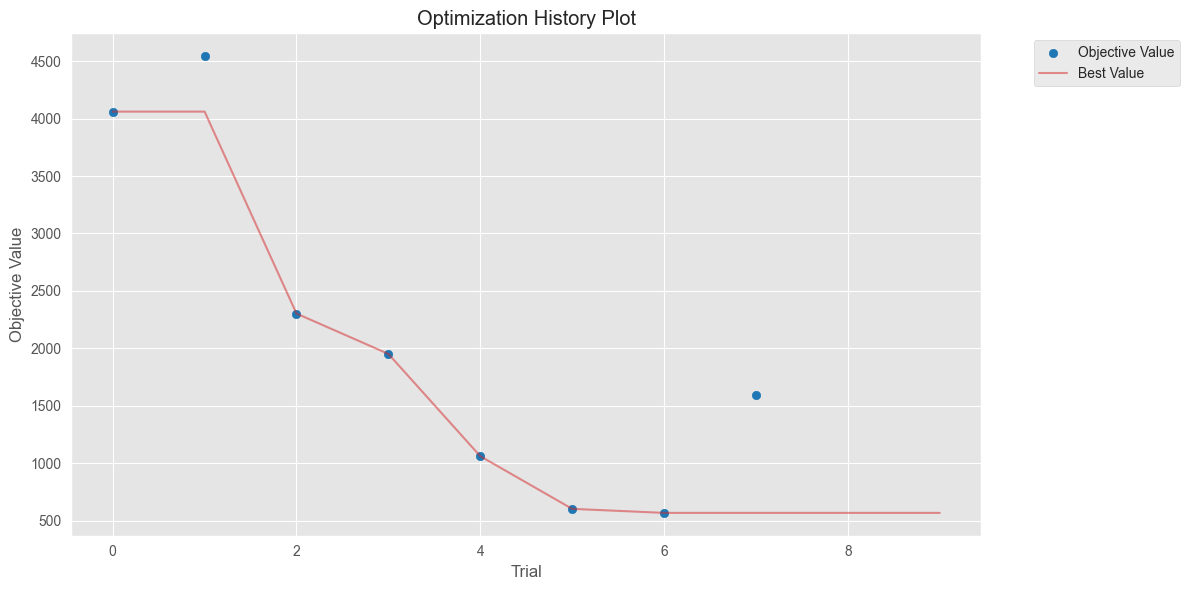

In [14]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_slice,
    plot_param_importances,
)
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_NN"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')


In [ ]:
best_params = study.best_trial.params
print("Best params for final model:", best_params)

# dataloaders using best batch size
batch_size_best = best_params.get("batch_size", 128)
train_loader, val_loader, test_loader = create_dataloaders(batch_size_best)

# final model
model = TransformerRegressor(
    input_dim=input_dim,
    d_model=best_params["d_model"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"],
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_rmse": [],
    "val_rmse": []
}

num_epochs = 150
best_val_loss = float("inf")
best_state = None

for epoch in range(num_epochs):

    # ---- train ----
    train_loss, train_preds, train_targets = run_epoch(
        train_loader, model, criterion, optimizer
    )
    train_rmse = compute_rmse(train_targets, train_preds)

    # ---- validate ----
    val_loss, val_preds, val_targets = run_epoch(
        val_loader, model, criterion, optimizer=None
    )
    val_rmse = compute_rmse(val_targets, val_preds)

    scheduler.step(val_loss)

    # store history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    # track best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()

    # print in your preferred style
    if epoch == 0 or (epoch % 20 == 0) or epoch == num_epochs - 1:
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}"
        )

# load best weights
if best_state is not None:
    model.load_state_dict(best_state)

print(f"\nBest validation loss (MSE): {best_val_loss:.4f}")


In [ ]:
# ---- RMSE curves ----
epochs = range(len(history["train_rmse"]))

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_rmse"], label="Train RMSE", linewidth=2)
plt.plot(epochs, history["val_rmse"], label="Validation RMSE", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Transformer – Train vs Validation RMSE (Best Hyperparams)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---- Test evaluation ----
test_loss, test_preds, test_targets = run_epoch(
    test_loader, model, criterion, optimizer=None
)

test_preds = test_preds.reshape(-1)
test_targets = test_targets.reshape(-1)

test_rmse = compute_rmse(test_targets, test_preds)
test_r2   = r2_score(test_targets, test_preds)

print(f"Test MSE:  {test_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²:   {test_r2:.4f}")

# optional: predicted vs true scatter
plt.figure(figsize=(6, 6))
plt.scatter(test_targets, test_preds, alpha=0.3)
lim_min = min(test_targets.min(), test_preds.min())
lim_max = max(test_targets.max(), test_preds.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle="--")
plt.xlabel("True Yield")
plt.ylabel("Predicted Yield")
title_crop = CHOSEN_CROP if "CHOSEN_CROP" in globals() else "Crop"
plt.title(f"Transformer (Optuna Best) – {title_crop} – Test Set")
plt.grid(alpha=0.3)
plt.show()
